<a href="https://colab.research.google.com/github/Imokutmfon/ml4sci/blob/main/Common%20Test%201/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
import zipfile
import gdown
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns

# Data Preprocessing

In [2]:
# Set url and download paths
file_id = '1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ'
zip_file = 'dataset.zip'
url = f'https://drive.google.com/uc?id={file_id}'
extract_dir = 'extracted_contents'

In [3]:
# Function to download and extract dataset
def download_and_extract_data(url, zip_file, extract_dir):
    gdown.download(url, zip_file, quiet=False)
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

In [4]:
# Download and extract dataset
download_and_extract_data(url=url, zip_file=zip_file, extract_dir=extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=c0848232-436c-4964-928b-d3c7dad4410c
To: /content/dataset.zip
100%|██████████| 1.13G/1.13G [00:16<00:00, 68.1MB/s]


In [5]:
# Set paths
BASE_DIR = os.path.join(extract_dir, 'dataset')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
CLASSES = ['no', 'sphere', 'vort']


In [6]:
def count_samples(directory, classes):
    """Count the number of samples in each class and total"""
    counts = {}
    total = 0

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        file_count = len([f for f in os.listdir(class_dir) if f.endswith('.npy')])
        counts[class_name] = file_count
        total += file_count

    return counts, total


In [7]:
# Get dataset stats without loading all data
train_counts, train_total = count_samples(TRAIN_DIR, CLASSES)
val_counts, val_total = count_samples(VAL_DIR, CLASSES)

# Print dataset information
print(f"Training samples: {train_total} ({train_counts})")
print(f"Validation samples: {val_total} ({val_counts})")

Training samples: 30000 ({'no': 10000, 'sphere': 10000, 'vort': 10000})
Validation samples: 7500 ({'no': 2500, 'sphere': 2500, 'vort': 2500})


In [8]:
# Create a data generator to load and process images on-the-fly
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, classes, batch_size=32, shuffle=True, augment=False):
        self.directory = directory
        self.classes = classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        # Build list of file paths and labels
        self.file_paths = []
        self.labels = []

        for idx, class_name in enumerate(classes):
            class_dir = os.path.join(directory, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    self.file_paths.append(os.path.join(class_dir, file_name))
                    self.labels.append(idx)

        self.indices = np.arange(len(self.file_paths))
        self.on_epoch_end()

        # Create augmentation pipeline if needed
        if self.augment:
            self.augmentation = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.1),
                layers.RandomZoom(0.1),
            ])

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indices of the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialize batch arrays
        batch_x = []
        batch_y = []

        # Generate data
        for idx in batch_indices:
            # Load and process image
            img = np.load(self.file_paths[idx])
            # Reshape from (1, 150, 150) to (150, 150, 1) for CNN input
            img = np.transpose(img, (1, 2, 0))
            # Normalize
            img = img / np.max(img) if np.max(img) > 0 else img

            # Apply augmentation if enabled
            if self.augment:
                img = self.augmentation(img[np.newaxis, ...]).numpy()[0]

            batch_x.append(img)

            # One-hot encode the label
            label = np.zeros(len(self.classes))
            label[self.labels[idx]] = 1
            batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        """Shuffle indices after each epoch if shuffle is True"""
        if self.shuffle:
            np.random.shuffle(self.indices)

In [9]:
train_generator = DataGenerator(TRAIN_DIR, CLASSES, batch_size=32, shuffle=True, augment=True)
val_generator = DataGenerator(VAL_DIR, CLASSES, batch_size=32, shuffle=False)

In [10]:
# Visualize a few samples from the generator
def visualize_samples_from_generator(generator, num_samples=5):
    # Get a batch of data
    images, labels = generator[0]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i].squeeze(), cmap='viridis')
        class_idx = np.argmax(labels[i])
        axes[i].set_title(f"Class: {CLASSES[class_idx]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

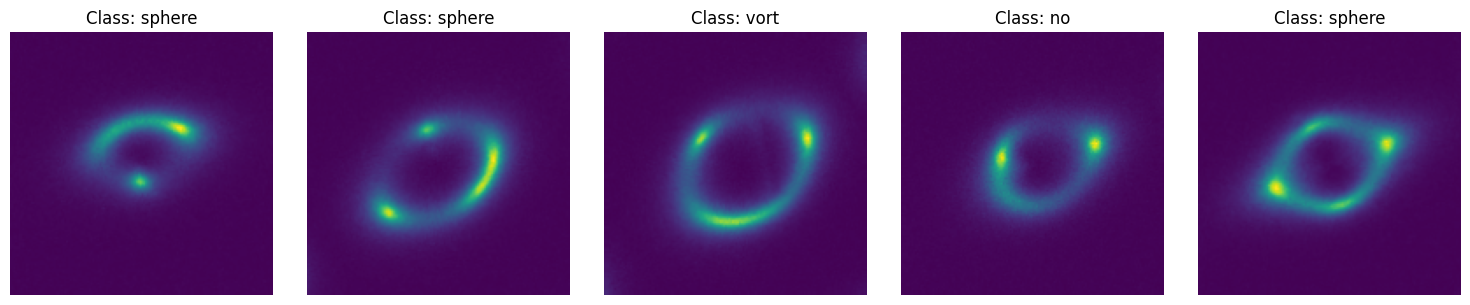

In [11]:
visualize_samples_from_generator(train_generator)

# Model

In [12]:
# Model architecture - using a CNN approach suitable for astronomical images
def create_model(input_shape=(150, 150, 1)):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(CLASSES), activation='softmax')
    ])

    return model


In [13]:

# Create the model
model = create_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,796,451 (45.00 MB)

 Trainable params: 11,793,507 (44.99 MB)

 Non-trainable params: 2,944 (11.50 KB)

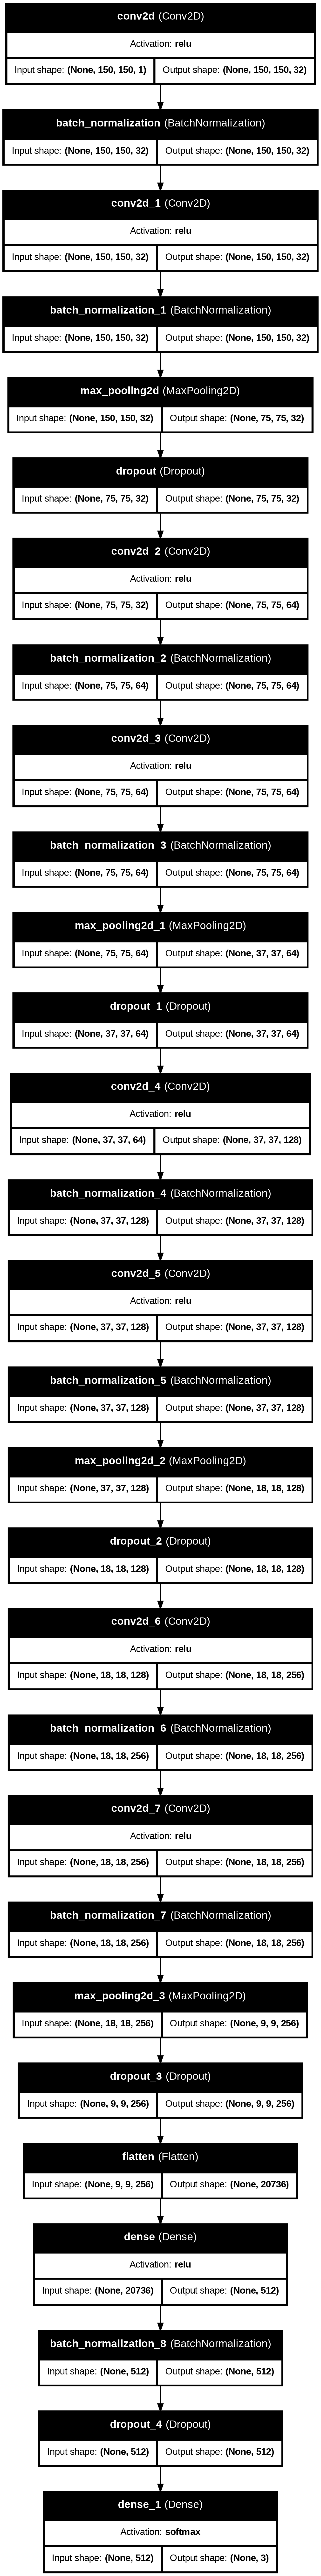

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [17]:

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:

# Define callbacks for training
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


In [19]:
def train_with_generators(model, train_gen, val_gen, epochs=50):
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
# Train the model with generators
history = train_with_generators(model, train_generator, val_generator)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 11/938 ━━━━━━━━━━━━━━━━━━━━ 2:39:40 10s/step - accuracy: 0.3408 - loss: 2.1471

In [ ]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate the model using the generator
def evaluate_model(model, val_generator):
    # Get all validation data for evaluation
    # We need to gather all batches for proper evaluation
    all_y_true = []
    all_y_pred = []

    print("Evaluating model on validation data...")
    for i in range(len(val_generator)):
        x_batch, y_true_batch = val_generator[i]
        y_pred_batch = model.predict(x_batch, verbose=0)

        all_y_true.append(y_true_batch)
        all_y_pred.append(y_pred_batch)

    # Concatenate all batches
    y_true = np.vstack(all_y_true)
    y_pred = np.vstack(all_y_pred)

    # Get class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC Score evaluation
    # For multiclass ROC curve, we use one-vs-rest approach
    n_classes = len(CLASSES)

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {CLASSES[i]} (area = {roc_auc[i]:.2f})')

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Compute macro-average AUC score
    macro_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')
    print(f"\nMacro-average AUC: {macro_auc:.4f}")
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")

    # Print class-specific AUC scores
    print("\nClass-specific AUC scores:")
    for i in range(n_classes):
        print(f"{CLASSES[i]}: {roc_auc[i]:.4f}")

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Transfer learning approach with ResNet50
def create_transfer_model(input_shape=(150, 150, 1)):
    # Convert grayscale to RGB by repeating channels
    inputs = layers.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs])  # Duplicate the channel 3 times

    # Use pre-trained ResNet50 (without top layers)
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom classification head
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model